
# Gradcam example for ImageNet, ResNet50


## References
***
- Darkon Documentation: http://darkon.io
- Darkon Github: https://github.com/darkonhub/darkon
- Resnet code: https://github.com/tensorflow/models/blob/master/research/slim/nets/resnet_v1.py
- Imagenet model: http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz
- More examples: https://github.com/darkonhub/darkon-examples


## prepare
***
for cpu
```
pip install -r requirements.txt
pip install tensorflow
```

for gpu
```
pip install -r requirements.txt
pip install tensorflow-gpu
```

## Import packages

In [1]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.contrib.slim.nets import resnet_v1
import tensorflow.contrib.slim as slim
from imagenet_decoder import imagenet_decoder

import darkon

# to enable specific GPU
%set_env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


## build resnet network

In [2]:
tf.reset_default_graph()
nclasses = 1000
inputs = tf.placeholder(tf.float32, [1,224,224,3])

#load network resnet50
with slim.arg_scope(resnet_v1.resnet_arg_scope()):
    net, end_points = resnet_v1.resnet_v1_50(inputs, nclasses, is_training=False)

## restore pretrained resnet model

In [3]:
#restore pretrained model
saver = tf.train.Saver(tf.global_variables())
check_point = 'test/data/resnet_v1_50.ckpt'
sess = tf.InteractiveSession()
saver.restore(sess, check_point)

graph = tf.get_default_graph()
print(darkon.Gradcam.candidate_featuremap_op_names(sess, graph)[-5:])

INFO:tensorflow:Restoring parameters from test/data/resnet_v1_50.ckpt
[u'resnet_v1_50/block4/unit_3/bottleneck_v1/conv2/Relu', u'resnet_v1_50/block4/unit_3/bottleneck_v1/conv3/Conv2D', u'resnet_v1_50/block4/unit_3/bottleneck_v1/conv3/BatchNorm/FusedBatchNorm', u'resnet_v1_50/block4/unit_3/bottleneck_v1/add', u'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu']


choose 'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu' as targer layer

In [4]:
conv_name = 'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu'
insp = darkon.Gradcam(inputs, nclasses, conv_name, graph = graph)

Load test image 'cat_dog.png'

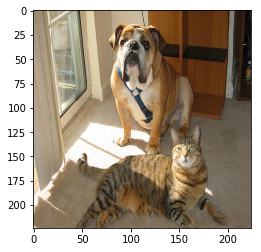

In [5]:
image1 = cv2.imread('test/data/cat_dog.png')
image1_cvt = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.imshow(image1_cvt)

image1 = image1.astype(np.float)

Get top5 most probable predction of 'cat_dog.png'

In [6]:
probs = insp._prob_ts
probs_eval = sess.run(probs,feed_dict={inputs:np.reshape(image1,(1,224,224,3))})
top5_result = imagenet_decoder(probs_eval)
print(top5_result)

[('tiger cat', 282), ('boxer', 242), ('Great Dane', 246), ('tabby, tabby cat', 281), ('bull mastiff', 243)]


Resnet50 predict 'cat_dog.png' as 'tiger cat' as most probable category, 'boxer' as second, and 'Great Dane' as third 
____

show gradcam and guided_gradcam of top5 predictions of 'cat_dog.png' 

Gradcam and guided gradcam will show which pixels affected the prediction.

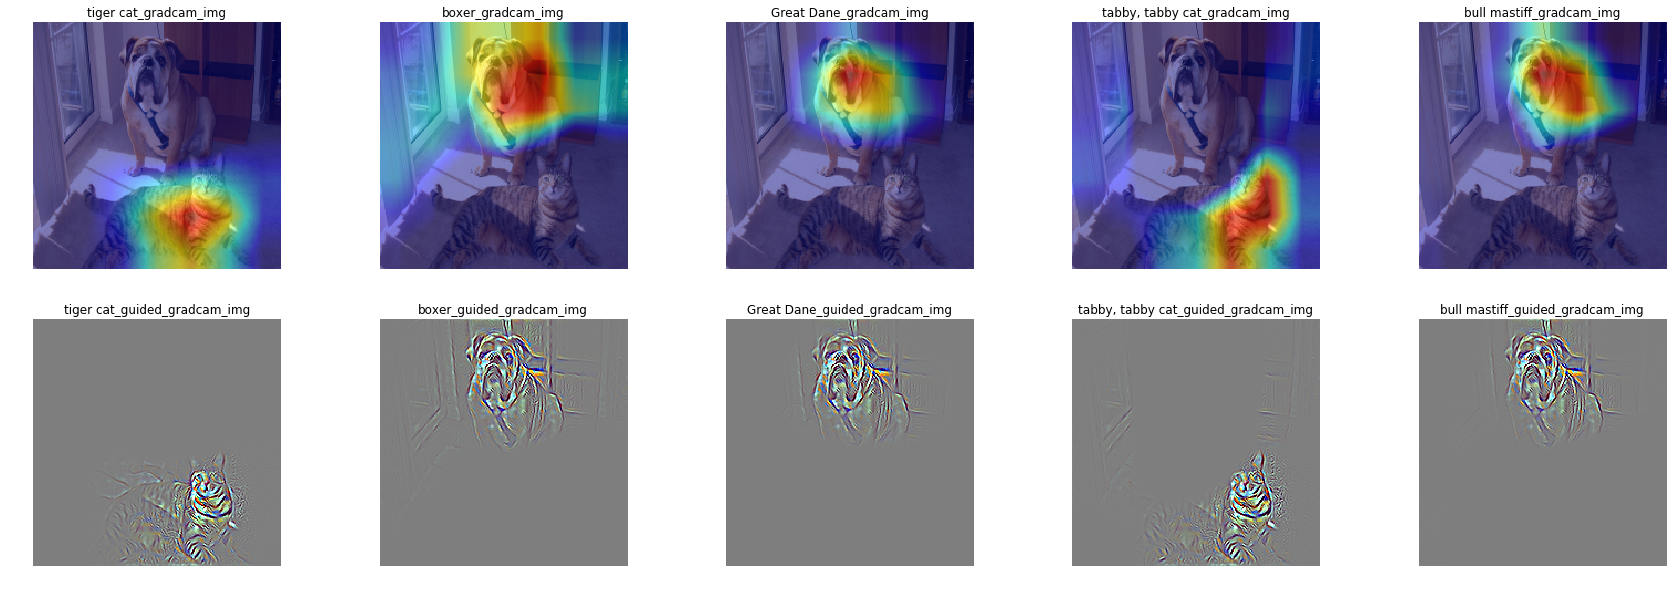

In [7]:
fig, axes1 = plt.subplots(2, 5, figsize=(30, 10))
for j in range(5):
    ret = insp.gradcam(sess, image1, top5_result[j][1])
    axes1[0][j].set_axis_off()
    axes1[0][j].imshow(cv2.cvtColor(ret['gradcam_img'], cv2.COLOR_BGR2RGB))
    axes1[0][j].set_title('{}_gradcam_img'.format(top5_result[j][0]))

    axes1[1][j].set_axis_off()
    axes1[1][j].imshow(cv2.cvtColor(ret['guided_gradcam_img'], cv2.COLOR_BGR2RGB))
    axes1[1][j].set_title('{}_guided_gradcam_img'.format(top5_result[j][0]))


When Resnet50 judge 'cat_dog.png' as 

Load second image

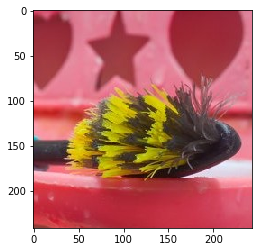

In [8]:
image2 = cv2.imread('test/data/tooth_brush.png')
plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))

image2 = image2.astype(np.float)
image2 = cv2.resize(image2, (224, 224))

get top5 most probable prediction of 'tooth_brush.png'

In [9]:
probs = insp._prob_ts
probs_eval = sess.run(probs,feed_dict={inputs:np.reshape(image2,(1,224,224,3))})
top5_result = imagenet_decoder(probs_eval)
print(top5_result)

[('paintbrush', 696), ('sea urchin', 328), ('vase', 883), ('lighter, light, igniter, ignitor', 626), ('peacock', 84)]


Resnet50 predict 'tooth_brush.png' as 'paint' as most probable category, 'sea urchin' as second, and 'vase' as third 
____

Show gradcam and guided_gradcam of top5 predictions of 'tooth_brush.png' 

Gradcam and guided gradcam will show which pixels affected the prediction.

/home/sunghwan/darkon/darkon/gradcam/gradcam.py:144: RuntimeWarning: invalid value encountered in true_divide
  heatmap = cam / np.max(cam)


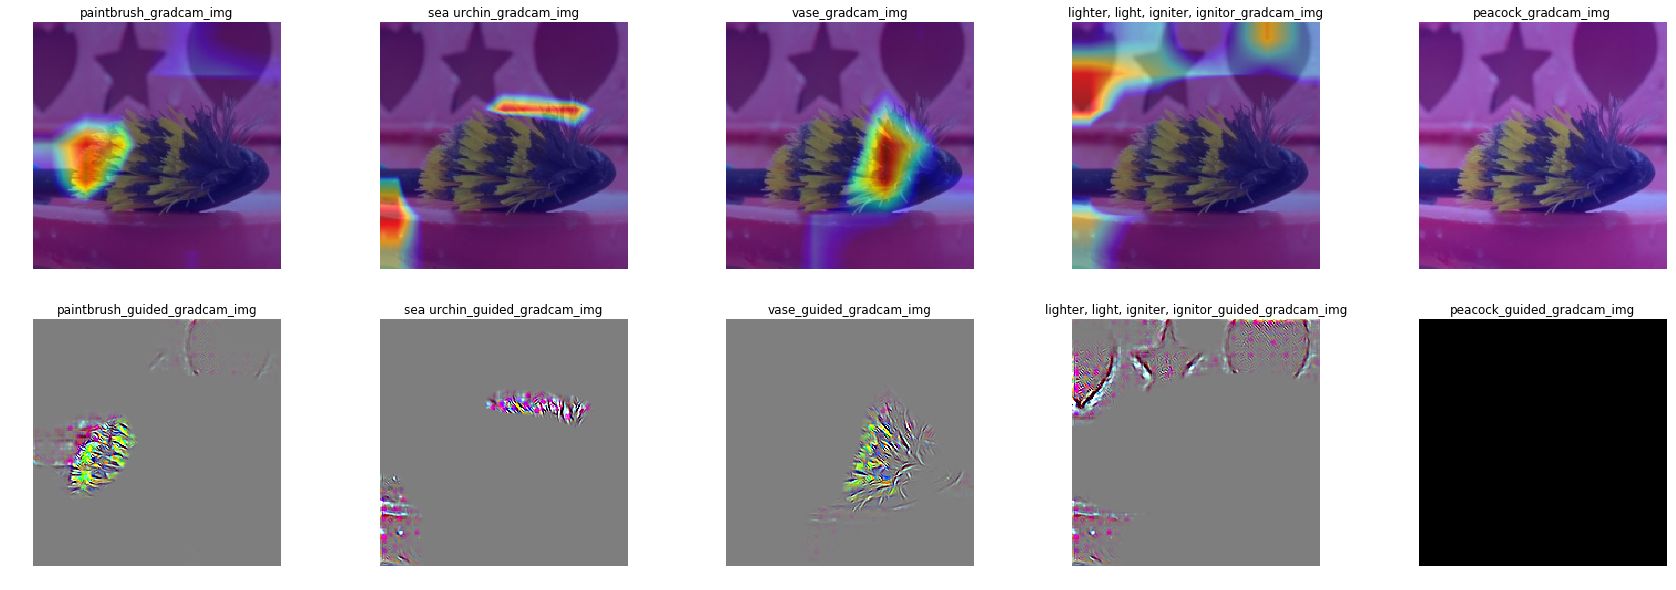

In [10]:
fig, axes1 = plt.subplots(2, 5, figsize=(30, 10))
for j in range(5):
    ret = insp.gradcam(sess, image2, top5_result[j][1])
    axes1[0][j].set_axis_off()
    axes1[0][j].imshow(cv2.cvtColor(ret['gradcam_img'], cv2.COLOR_BGR2RGB))
    axes1[0][j].set_title('{}_gradcam_img'.format(top5_result[j][0]))

    axes1[1][j].set_axis_off()
    axes1[1][j].imshow(cv2.cvtColor(ret['guided_gradcam_img'], cv2.COLOR_BGR2RGB))
    axes1[1][j].set_title('{}_guided_gradcam_img'.format(top5_result[j][0]))


When Resnet50 judge 'tooth_brush.png' as 'paintbrush', the bottom part of tooth brush done important role. On the other hand, when it judge 'tooth_brush.png' as 'see urchin', the upper part of black jagged brushes make a standard for prediction. However, the middle part of tooth brush let resnet50 to judge 'tooth_brush.png' as 'vase'.

### License

---
<pre>
Copyright 2017 Neosapience, Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
</pre>

---